In [409]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl

In [4]:
# Load the dataset
data = np.load('public_data.npz', allow_pickle=True)
# Assuming the dataset has two arrays 'X' for features and 'y' for labels
X = data['data']  # Assuming this is your feature data
y = data['labels']  # Assuming this is your label data

In [5]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (5200, 96, 96, 3)
Shape of y: (5200,)


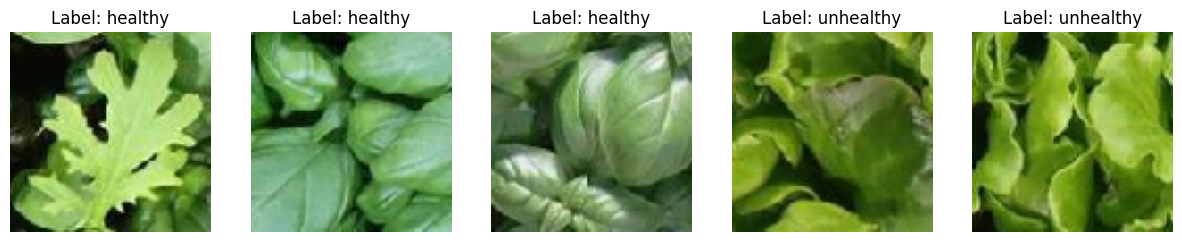

In [6]:
# Check if scaling is needed
if X.max() > 1.0:
    X = X.astype('float32') / 255.0

# Now, the images should be properly scaled. Let's try displaying them again.
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X[i])
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.show()

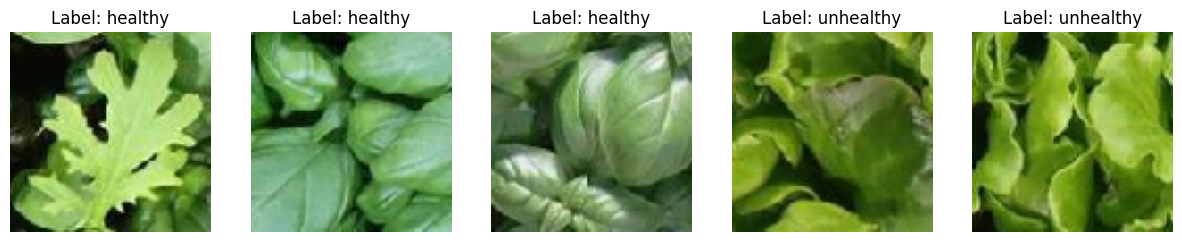

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X[i])
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.show()

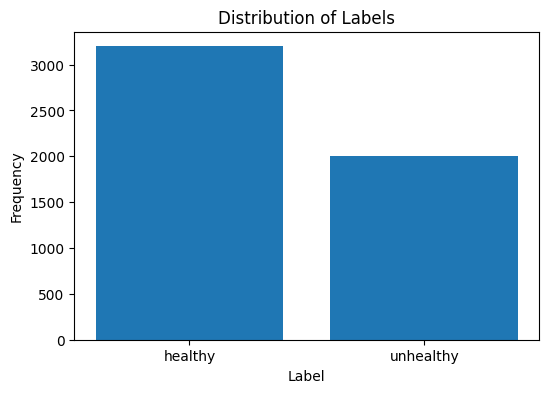

In [8]:
plt.figure(figsize=(6, 4))
plt.hist(y, bins=np.arange(-0.5, 2, 1), rwidth=0.8)
plt.title("Distribution of Labels")
plt.xticks([0, 1])
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

In [9]:
# Basic Statistical Analysis on Pixel Values
mean_pixel_values = X.mean(axis=(0, 1, 2))
std_pixel_values = X.std(axis=(0, 1, 2))
print(f"Mean pixel values (RGB): {mean_pixel_values}")
print(f"Standard deviation of pixel values (RGB): {std_pixel_values}")

Mean pixel values (RGB): [0.3074494  0.35008547 0.21965173]
Standard deviation of pixel values (RGB): [0.18970086 0.23425534 0.18129332]


In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.preprocessing.image import img_to_array, array_to_img

# Load pre-trained VGG16 model without the classification layers
model = InceptionResNetV2(include_top=False, input_shape=(96, 96, 3), weights='imagenet')

# Preprocess images and get feature vectors
def extract_features(images):
    features = []
    for image in images:
        # Resize image to 96x96 if not already
        if image.shape != (96, 96, 3):
            image = array_to_img(image)
            image = image.resize((96, 96))
            image = img_to_array(image)
        # Preprocess the image for the VGG16 model
        image = preprocess_input(image)
        # Get features
        feature = model.predict(image.reshape(1, 96, 96, 3))
        # Flatten the features
        features.append(feature.flatten())
    return np.array(features)

# Extract features from the images
X_features = extract_features(X)

1/1 [==============================] - 1s 585ms/step


In [13]:
X_features_backup = X_features.copy()

In [14]:
# Apply PCA to reduce the dimensionality before t-SNE
pca = PCA(n_components=50)  # Reduce to 50 dimensions
X_pca = pca.fit_transform(X_features)

# Apply t-SNE to further reduce to 2 dimensions
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_pca)

C:\Users\gusta\AppData\Local\Temp\ipykernel_24788\1467957641.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


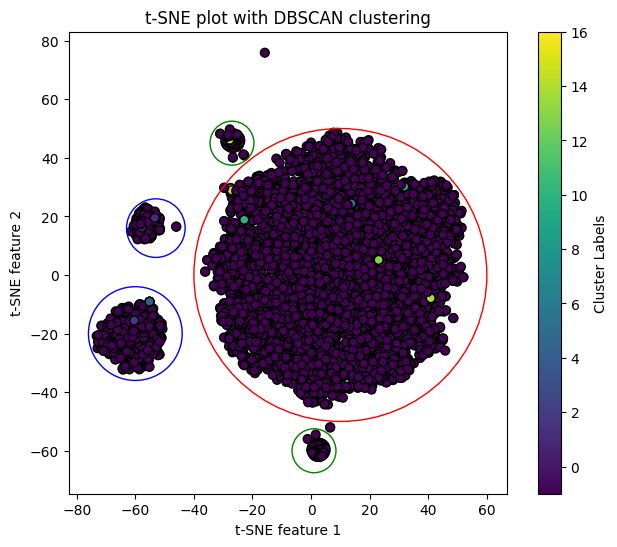

In [126]:
# Apply DBSCAN clustering algorithm
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_tsne)

# Manually create 5 circles to represent the 5 clusters
biggest_circle = plt.Circle((10, 0), radius=50, color='r', fill=False)
_2nd_biggest_circle = plt.Circle((-60, -20), radius=16, color='b', fill=False)
_3rd_biggest_circle = plt.Circle((-53, 16), radius=10, color='b', fill=False)
small_circle = plt.Circle((-27, 45), radius=7.5, color='g', fill=False)
_2nd_small_circle = plt.Circle((1, -60), radius=7.5, color='g', fill=False)

# Plot t-SNE reduced features with cluster labels
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', edgecolor='k', s=40)
ax.add_patch(biggest_circle)
ax.add_patch(_2nd_biggest_circle)
ax.add_patch(_3rd_biggest_circle)
ax.add_patch(small_circle)
ax.add_patch(_2nd_small_circle)
plt.title("t-SNE plot with DBSCAN clustering")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
# Create a ScalarMappable
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(clusters), vmax=max(clusters)))
sm.set_array([])  # empty array for the data range

# Add colorbar
cbar = plt.colorbar(sm)
cbar.set_label('Cluster Labels')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [26]:
# Rescale X to 0-1 range
X = data['data']/255.0

print("Shape of X:", X_tsne.shape)
print(X_tsne.max(), X_tsne.min())

Shape of X: (5200, 2)
75.872986 -73.18745


In [366]:
def inside_circle(x, y, radius, center=(0, 0)):
    return (x - center[0])**2 + (y - center[1])**2 < radius**2

# Get indices of points inside the big circle
indices = []
for i in range(len(X_tsne)):
    if inside_circle(X_tsne[i, 0], X_tsne[i, 1], 50, (10, 0)):
        indices.append(i)
indices = np.array(indices)

# Get indices of points inside the 2nd biggest circle
indices_2nd = []
for i in range(len(X_tsne)):
    if inside_circle(X_tsne[i, 0], X_tsne[i, 1], 16, (-60, -20)):
        indices_2nd.append(i)
indices_2nd = np.array(indices_2nd)

# Get indices of points inside the 3rd biggest circle
indices_3rd = []
for i in range(len(X_tsne)):
    if inside_circle(X_tsne[i, 0], X_tsne[i, 1], 10, (-53, 16)):
        indices_3rd.append(i)
indices_3rd = np.array(indices_3rd)

# Get indices of points inside the small circle
indices_small = []
for i in range(len(X_tsne)):
    if inside_circle(X_tsne[i, 0], X_tsne[i, 1], 7.5, (-27, 45)):
        indices_small.append(i)
indices_small = np.array(indices_small)

# Get indices of points inside the 2nd small circle
indices_2nd_small = []
for i in range(len(X_tsne)):
    if inside_circle(X_tsne[i, 0], X_tsne[i, 1], 7.5, (1, -60)):
        indices_2nd_small.append(i)
indices_2nd_small = np.array(indices_2nd_small)



print("Number of points inside the big circle:", len(indices))
print("Number of points outside the big circle:", len(X_tsne) - len(indices))

images_inside_circle = X[indices]
labels_inside_circle = y[indices]

images_inside_2nd_circle = X[indices_2nd]
labels_inside_2nd_circle = y[indices_2nd]

images_inside_3rd_circle = X[indices_3rd]
labels_inside_3rd_circle = y[indices_3rd]

images_inside_small_circle = X[indices_small]
labels_inside_small_circle = y[indices_small]

images_inside_2nd_small_circle = X[indices_2nd_small]
labels_inside_2nd_small_circle = y[indices_2nd_small]

images_outside_big_circle = np.delete(X.copy(), indices, axis=0)
labels_outside__big_circle = np.delete(y.copy(), indices, axis=0)


Number of points inside the circle: 4391
Number of points outside the circle: 809


In [1]:
# Find outlier clusters or those that don't represent plants
# This requires some manual inspection after plotting
# the images in each cluster

# Plot a random subset of images from cluster ind
ind = 16
cluster_images = X[clusters == ind]    # Shrek == 2 and 12, Trololol == 4, 16
non_cluster_images = X[clusters != 2]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    random_image = random.choice(cluster_images)
    ax.imshow(random_image)
    ax.axis('off')
plt.show()



# Manually inspect pictures in each cluster (circle)
# Change the indices to inspect different clusters

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    index = indices
    j = random.randint(index[0], index[-1])
    ax.title.set_text(f"Label: {clusters[j]}")
    ax.imshow(X[j])
    ax.axis('off')
plt.show()

# Display how many images are in each cluster
print(sum(clusters))
# Separate the outlier images based on your inspection
# You might need to iterate the eps and min_samples parameters of DBSCAN
# as well as the number of components for PCA and t-SNE to get a good separation.

NameError: name 'X' is not defined

In [407]:
# Find indices of inlier images (not in clusters 2, 12, 4, 16)
inlier_indices = (clusters != 2) & (clusters != 12) & (clusters != 4) & (clusters != 16)
inlier_indices = np.array(inlier_indices)

# Get the indices of images inside the big circle
indices_ = [True if i in indices else False for i in range(len(inlier_indices))]
indices_ = np.array(indices_)
print(indices_.shape, inlier_indices.shape)
print(indices_)# indices = np.min(inlier_indices, indices, )

# Get the indices of images inside the big circle and not in clusters 2, 12, 4, 16
common_indices = indices_ & inlier_indices

# Get the images and labels of the inlier images
X_clean = X[common_indices]
y_clean = y[common_indices]

# Get the images and labels of images not in clusters 2, 12, 4, 16, but possibly outside the big circle
X_clean2 = X[inlier_indices]
y_clean2 = y[inlier_indices]


# Save the images not in clusters 2, 12, 4, 16, but possibly outside the big circle
np.savez_compressed('clean_data2.npz', data=X_clean2, labels=y_clean2)

X_dirty = X[~common_indices]
y_dirty = y[~common_indices]

# Save the images in clusters 2, 12, 4, 16, and inside the big circle
np.savez_compressed('clean_data.npz', data=X_clean, labels=y_clean)

(5200,) (5200,)
[False False False ...  True  True  True]
(5179, 96, 96, 3) (4391,)


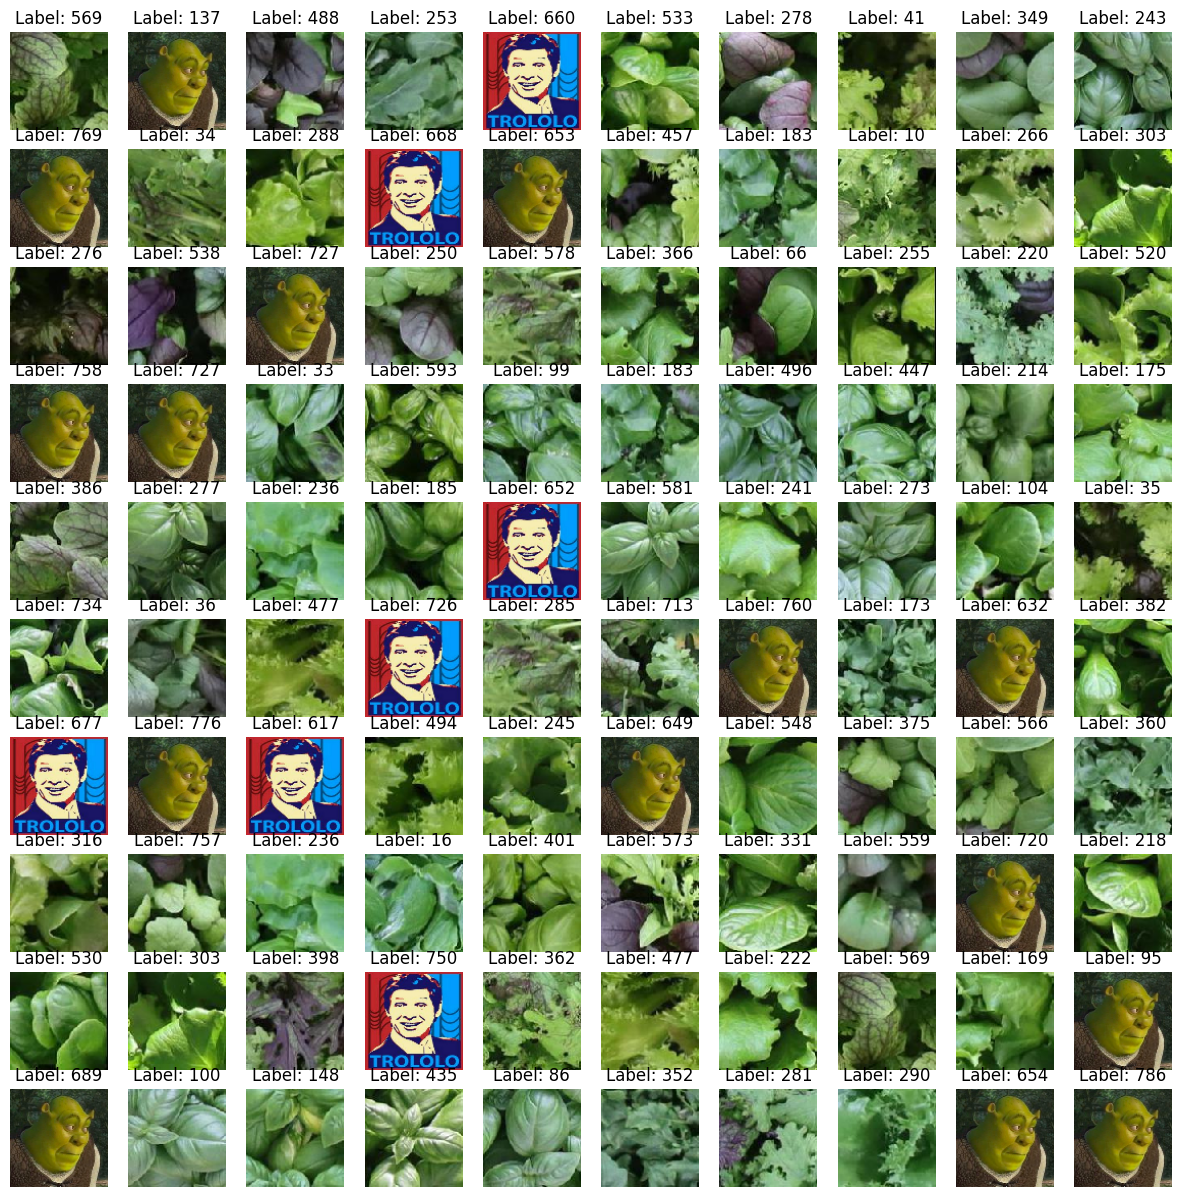

In [406]:
# Verification

# Plot all the images in the dataset in sets of 10

# Get 100 random indices
random_indices = np.random.randint(0, len(X_dirty), size=100)

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_dirty[random_indices[i]])
    ax.set_title(f"Label: {random_indices[i]}")
    ax.axis('off')
plt.show()

In [89]:
# Check the distribution of labels
labels, count = np.unique(y_clean, return_counts=True)
print("Distribution of labels in the clean dataset: ", dict(zip(labels, count)))

Distribution of labels in the clean dataset:  {'healthy': 2721, 'unhealthy': 1670}


In [2]:
# Plot the tsn-e plot with DBSCAN clustering on the clean dataset

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_tsne[common_indices, 0], X_tsne[common_indices, 1], c=clusters[common_indices], cmap='viridis', edgecolor='k', s=40)
# Create a ScalarMappable
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(clusters), vmax=max(clusters)))
sm.set_array([])  # empty array for the data range

# Add colorbar
cbar = plt.colorbar(sm)
cbar.set_label('Cluster Labels')



NameError: name 'plt' is not defined